We'll be using this library to implement the TCN: https://pypi.org/project/pytorch-tcn/1.0.0/ which is based on this paper: https://arxiv.org/abs/1803.01271

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import optuna
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from pytorch_tcn import TCN

In [2]:
# Define the file path
file_path = 'https://media.githubusercontent.com/media/iamj4ckie/shared-project-data/refs/heads/main/data/wind_speed_13_n.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

df.head()

,Mx1,Mx2,Mx3,My1,My2,My3,Mz1,Mz2,Mz3,Theta,...,Vwy,Vwz,beta1,beta2,beta3,dbeta1,dbeta2,dbeta3,omega_r,t
0,5669.242169,588.682952,-2283.570120,12206.506791,6735.678178,9289.590353,-46.636673,-0.763518,57.837418,0.892055,...,2.716019,0.062275,0.056162,0.054724,0.054979,0.004734,-0.000343,-0.000591,12.056893,0.00000
1,6059.851372,77.800854,-2110.975042,11765.633220,7146.208774,8781.542941,-47.358326,-0.786074,58.079163,0.927567,...,2.604409,-0.010360,0.056089,0.054646,0.054902,0.004317,-0.000806,-0.001110,12.064904,0.00625
2,5694.798598,614.439242,-2373.027775,12197.570281,6665.876391,8928.649687,-48.055740,-0.761416,58.283371,0.916719,...,2.871704,0.164501,0.056617,0.055168,0.055424,0.003857,-0.001303,-0.001663,12.064869,0.01250
3,5647.114990,493.144220,-2300.119212,11914.937535,7348.576783,8595.999193,-48.655266,-0.814706,58.498627,0.942775,...,3.027272,0.295967,0.056115,0.054658,0.054913,0.004329,-0.000818,-0.001232,12.056639,0.01875
4,5720.660260,467.386734,-2085.456805,11910.216305,6819.000947,8303.087862,-49.212616,-0.787967,58.749008,0.959359,...,2.997196,0.168861,0.056623,0.055156,0.055411,0.003878,-0.001286,-0.001756,12.047874,0.02500


In [3]:
# features = ['beta1', 'beta2', 'beta3', 'Theta', 'omega_r', 'Vwx']   # Mandatory input features
# features = ['Mx1', 'Mx2', 'Mx3', 'My1', 'My2', 'My3', 'Theta', 'Vwx', 'beta1', 'beta2', 'beta3', 'omega_r']   # Our selected input features
features = ['beta1', 'beta2', 'beta3', 'Theta', 'omega_r', 'Vwx', 'dbeta1', 'dbeta2', 'dbeta3', 'Mx1', 'Mx2', 'Mx3', 'My1', 'My2', 'My3', 'Vwy', 'Vwz']   # All input features

targets = ['Mz1', 'Mz2', 'Mz3']  # Output 

In [4]:
X = df[features].values
y = df[targets].values

In [5]:
# Normalize features and targets
scaler = StandardScaler()
X = scaler.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [6]:
# Create PyTorch dataset so we can use DataLoader function for train and test set creation
class WindTurbineDataset(Dataset):

    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [7]:
dataset = WindTurbineDataset(X, y)

In [8]:
# Set size for train, validation and test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [9]:
print("Training data")
print(f"Number of points: {len(train_set)}")
print("\nTest data")
print(f"Number of points: {len(test_set)}")

Training data
Number of points: 224000

Test data
Number of points: 96001


In [11]:
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, dropout):
        super(TCNModel, self).__init__()

        activation_fn = nn.ReLU()

        self.tcn = TCN(
            input_size,
            num_channels,
            dropout=dropout
        )

        # We need this layer to map the TCN ouput to the target size
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = self.tcn(x)
        x = self.fc(x[:, :, -1])
        return x

input_size = len(features)
output_size = len(targets)
num_channels = [32, 64, 128]
dropout = 0.18

model = TCNModel(input_size, output_size, num_channels, dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)


TCNModel(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          17, 32, kernel_size=(4,), stride=(1,)
          (padder): ConstantPad1d(padding=(3, 0), value=0.0)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          32, 32, kernel_size=(4,), stride=(1,)
          (padder): ConstantPad1d(padding=(3, 0), value=0.0)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.18, inplace=False)
        (dropout2): Dropout(p=0.18, inplace=False)
        (downsample): Conv1d(17, 32, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        

In [12]:
input_size = len(features)
output_size = len(targets)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the objective function
def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 0.00009, 0.0001)
    dropout = trial.suggest_uniform("dropout", 0.2, 0.3)
    num_channels = trial.suggest_categorical("num_channels", [[32, 64, 64], [64, 128, 128], [32, 64, 128]])

    model = TCNModel(input_size, output_size, num_channels, dropout)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 10
    patience = 3

    for epoch in range(max_epochs):
        model.train()
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            batch_features = batch_features.unsqueeze(2)

            predictions = model(batch_features).squeeze()
            loss = loss_fn(predictions, batch_targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_features, val_targets in test_loader:
                val_features, val_targets = val_features.to(device), val_targets.to(device)
                val_features = val_features.unsqueeze(2)
                val_predictions = model(val_features).squeeze()
                val_loss += loss_fn(val_predictions, val_targets).item()

        avg_val_loss = val_loss / len(test_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_val_loss

# Define and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)


[I 2024-12-19 10:37:22,932] A new study created in memory with name: no-name-e47033be-f56e-4115-946b-be173bae8340
C:\Users\ropet\AppData\Local\Temp\ipykernel_22432\3090527056.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.00009, 0.0001)
C:\Users\ropet\AppData\Local\Temp\ipykernel_22432\3090527056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform("dropout", 0.2, 0.3)
C:\Users\ropet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should b

In [13]:
learning_rate = 0.001

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
num_epochs = 300
#validation_every_steps = 100
validation_every_steps = len(train_loader) // 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []
epoch_train_losses = []
epoch_val_losses = []

# For early stopping
best_val_loss = float('inf')
patience = 300
patience_counter = 0


# Training loop
step = 0
batch_train_loss = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        batch_features = batch_features.unsqueeze(2)

        # Forward pass
        predictions = model(batch_features).squeeze()
        loss = loss_fn(predictions, batch_targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_train_loss += loss.item()
        epoch_train_loss += loss.item()
        step += 1

        if step % validation_every_steps == 0:
            avg_train_loss = batch_train_loss / validation_every_steps
            train_losses.append(avg_train_loss)
            batch_train_loss = 0

            model.eval()
            with torch.no_grad():
                val_loss = 0
                for val_features, val_targets in test_loader:
                    val_features, val_targets = val_features.to(device), val_targets.to(device)
                    val_features = val_features.unsqueeze(2)
                    val_predictions = model(val_features).squeeze()
                    val_loss += loss_fn(val_predictions, val_targets).item()

            avg_val_loss = val_loss / len(test_loader)
            val_losses.append(avg_val_loss)
            print(f"Step {step}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")
            model.train()

    remaining_steps = step % validation_every_steps or validation_every_steps
    if batch_train_loss > 0:
        avg_train_loss = batch_train_loss / remaining_steps
        train_losses.append(avg_train_loss)
        batch_train_loss = 0

    avg_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f}")

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_features, val_targets in test_loader:
            val_features, val_targets = val_features.to(device), val_targets.to(device)
            val_features = val_features.unsqueeze(2)
            val_predictions = model(val_features).squeeze()
            val_loss += loss_fn(val_predictions, val_targets).item()

    avg_val_loss = val_loss / len(test_loader)
    epoch_val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        print(f"New best validation loss: {best_val_loss:.4f}. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

    model.train()

print("Training complete!")

Epoch 1/300
Step 350: Training Loss = 0.1311, Validation Loss = 0.0541
Step 700: Training Loss = 0.0509, Validation Loss = 0.0424
Step 1050: Training Loss = 0.0434, Validation Loss = 0.0390
Step 1400: Training Loss = 0.0394, Validation Loss = 0.0378
Step 1750: Training Loss = 0.0383, Validation Loss = 0.0366
Step 2100: Training Loss = 0.0365, Validation Loss = 0.0339
Step 2450: Training Loss = 0.0354, Validation Loss = 0.0339
Step 2800: Training Loss = 0.0346, Validation Loss = 0.0328
Step 3150: Training Loss = 0.0332, Validation Loss = 0.0340
Step 3500: Training Loss = 0.0336, Validation Loss = 0.0317
Epoch 1: Training Loss = 0.0476
Epoch 1: Validation Loss = 0.0317
New best validation loss: 0.0317. Model saved.
Epoch 2/300
Step 3850: Training Loss = 0.0326, Validation Loss = 0.0319
Step 4200: Training Loss = 0.0321, Validation Loss = 0.0311
Step 4550: Training Loss = 0.0315, Validation Loss = 0.0304
Step 4900: Training Loss = 0.0316, Validation Loss = 0.0301
Step 5250: Training Loss 

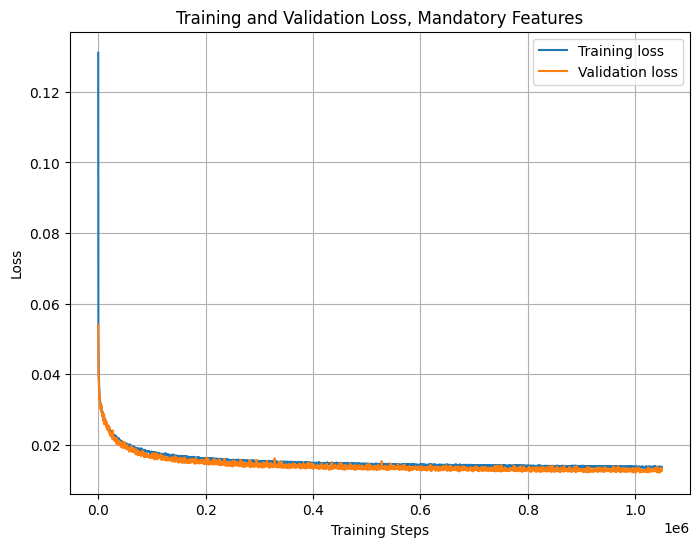

In [15]:
plt.figure(figsize=(8, 6))
plt.plot([i * validation_every_steps for i in range(len(train_losses))], train_losses, label="Training loss")
plt.plot([i * validation_every_steps for i in range(len(val_losses))], val_losses, label="Validation loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss, Mandatory Features")
plt.legend()
plt.grid()
plt.show()

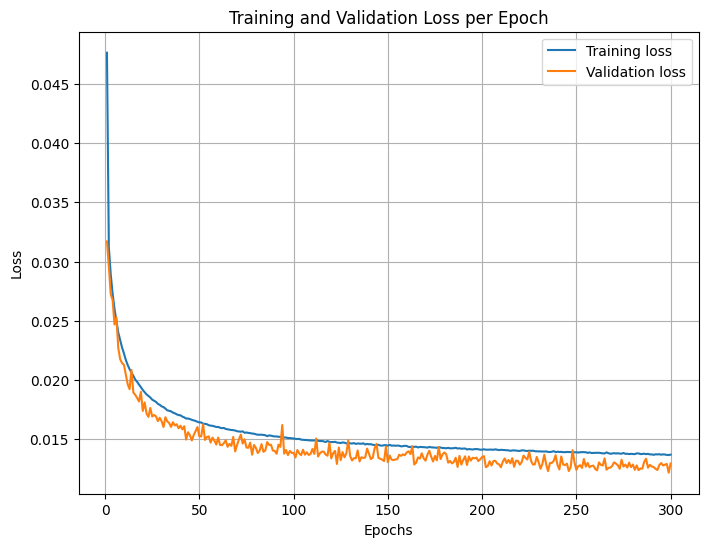

In [16]:
plt.figure(figsize=(8, 6))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, epoch_train_losses, label="Training loss")
plt.plot(epochs, epoch_val_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

C:\Users\ropet\AppData\Local\Temp\ipykernel_22432\4173142168.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


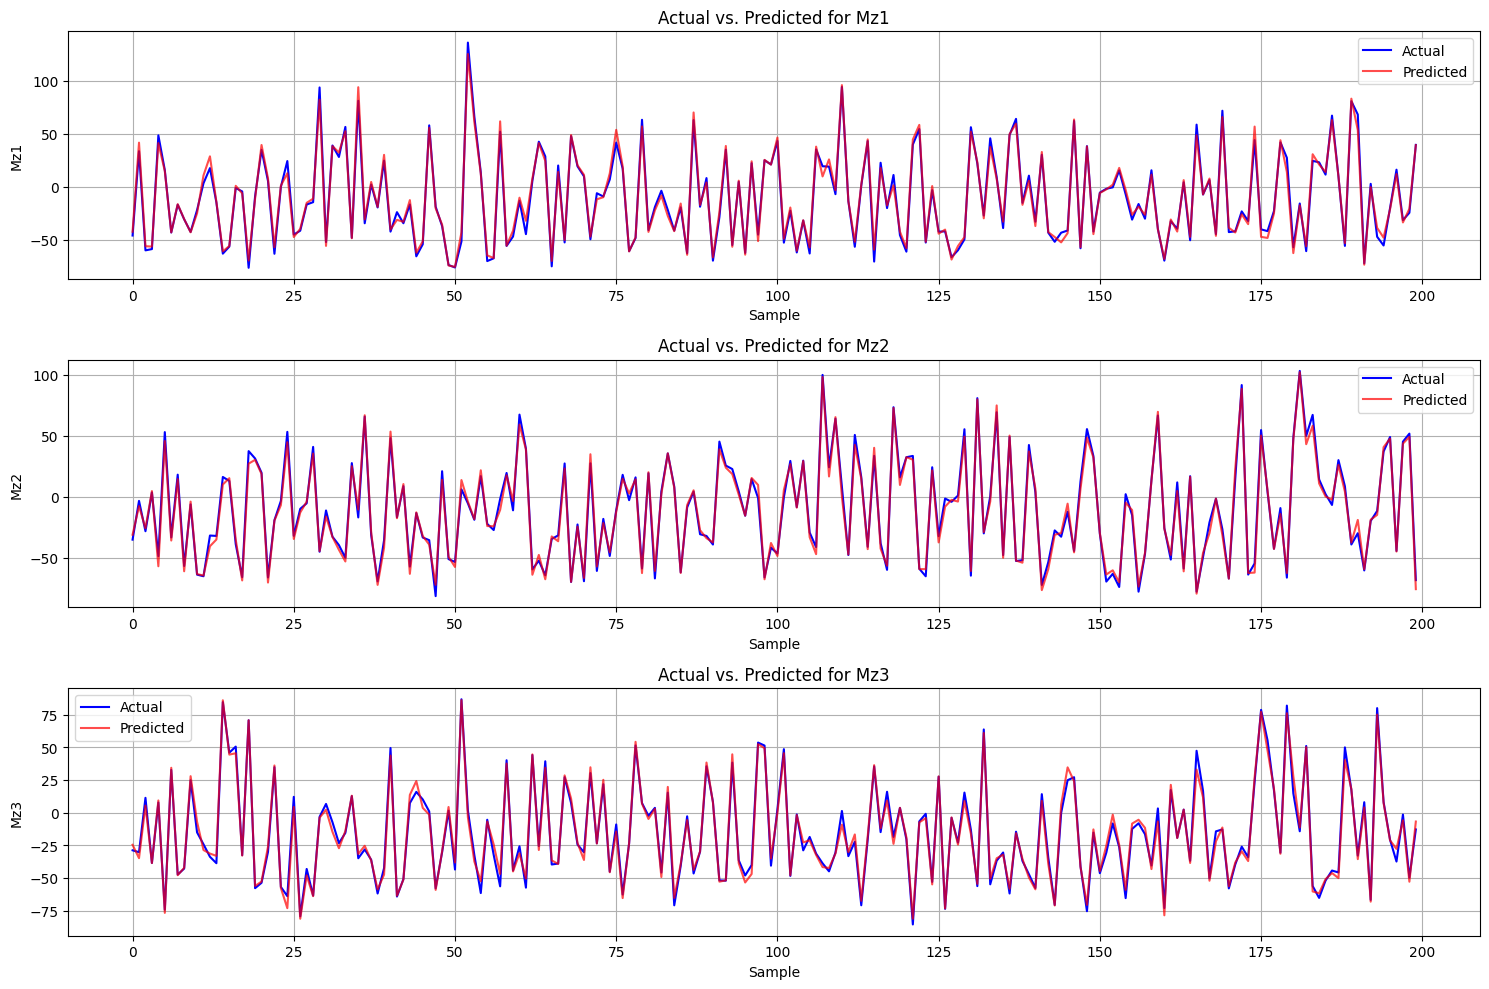

In [17]:
# Model in evaluation mode
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

actual_values = []
predicted_values = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x_batch = x_batch.unsqueeze(2)
        outputs = model(x_batch)
        actual_values.append(y_batch.cpu().numpy())
        predicted_values.append(outputs.cpu().numpy())

actual_values = np.concatenate(actual_values, axis=0)
predicted_values = np.concatenate(predicted_values, axis=0)

# Invert the scaling to get original values
# Separate scalers for X and y
actual_values_inv = scaler_y.inverse_transform(actual_values)
predicted_values_inv = scaler_y.inverse_transform(predicted_values)

target_names = targets  # ['Mz1', 'Mz2', 'Mz3']

num_samples_to_plot = 200
time_steps = np.arange(num_samples_to_plot)
plt.figure(figsize=(15, 10))

for i, target in enumerate(target_names):
    plt.subplot(len(target_names), 1, i+1)
    plt.plot(time_steps, actual_values_inv[:num_samples_to_plot, i], label='Actual', color='blue')
    plt.plot(time_steps, predicted_values_inv[:num_samples_to_plot, i], label='Predicted', color='red', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Sample')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the metrics
mae = mean_absolute_error(actual_values_inv, predicted_values_inv)
mse = mean_squared_error(actual_values_inv, predicted_values_inv)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values_inv, predicted_values_inv)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Evaluation Metrics:
Mean Absolute Error (MAE): 3.4285
Mean Squared Error (MSE): 18.9931
Root Mean Squared Error (RMSE): 4.3581
R-squared (R²): 0.9878
